# Result prediction based on Poison simulations

Source data: https://www.football-data.co.uk/englandm.php

In [1]:
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
cols = [
    "Season",
    "Date",
    "HomeTeam",
    "AwayTeam",
    "FTHG",
    "FTAG",
    "FTR",
]

In [3]:
csv_files = {
    "E2020_21.csv": "2020-21",
    "E2019_20.csv": "2019-20",
    "E2018_19.csv": "2018-19",
    "E2017_18.csv": "2017-18",
    "E2016_17.csv": "2016-17",
    "E2015_16.csv": "2015-16",
    "E2014_15.csv": "2014-15",
}

df = pd.DataFrame()

for file, season in csv_files.items():
    _data = pd.read_csv("data/" + file)
    _data["Season"] = season
    df = df.append(_data)

df = df[cols]

In [4]:
df["Date"] = pd.to_datetime(df["Date"])
df["TG"] = df["FTHG"] + df["FTAG"]

In [5]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2326 entries, 0 to 379
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Season    2326 non-null   object        
 1   Date      2326 non-null   datetime64[ns]
 2   HomeTeam  2326 non-null   object        
 3   AwayTeam  2326 non-null   object        
 4   FTHG      2326 non-null   float64       
 5   FTAG      2326 non-null   float64       
 6   FTR       2326 non-null   object        
 7   TG        2326 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(4)
memory usage: 163.5+ KB


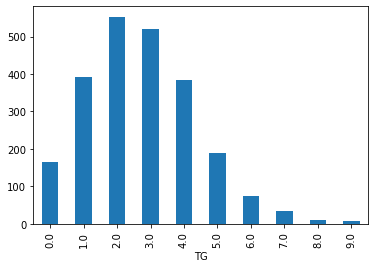

In [6]:
df.groupby("TG")["TG"].count().plot.bar();

In [7]:
df.sample(5)

,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,TG
19,2014-15,2014-08-25,Man City,Liverpool,3.0,1.0,H,4.0
159,2018-19,2018-10-12,Everton,Watford,2.0,2.0,D,4.0
320,2017-18,2018-07-04,Watford,Burnley,1.0,2.0,A,3.0
249,2016-17,2017-02-13,Bournemouth,Man City,0.0,2.0,A,2.0
107,2014-15,2014-09-11,Swansea,Arsenal,2.0,1.0,H,3.0


# Head to Head Pivot

In [8]:
head_to_head = df.groupby(["HomeTeam", "AwayTeam"]).agg(
    Matches=pd.NamedAgg(column="FTHG", aggfunc="count"),
    HSavg=pd.NamedAgg(column="FTHG", aggfunc="mean"),
    ASavg=pd.NamedAgg(column="FTAG", aggfunc="mean"),
)
head_to_head.shape

(770, 3)

In [9]:
head_to_head.reset_index().sample(5)

,HomeTeam,AwayTeam,Matches,HSavg,ASavg
724,West Ham,Cardiff,1,3.0,1.0
400,Man United,Burnley,5,1.4,1.4
488,Norwich,Sunderland,1,0.0,3.0
201,Crystal Palace,Norwich,2,1.5,0.0
382,Man City,Middlesbrough,1,1.0,1.0


# Simulation function

In [10]:
def get_result(h_score, a_score):
    if h_score > a_score:
        return "H"
    elif a_score > h_score:
        return "A"
    else:
        return "D"


def get_sim(home, away):
    if (home, away) not in head_to_head.index:
        return 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

    nsim = 500
    score_sim = []
    result_sim = {"H": 0, "D": 0, "A": 0}

    for i in range(nsim):
        h_score = np.random.poisson(head_to_head.loc[home, away]["HSavg"], 1)
        a_score = np.random.poisson(head_to_head.loc[home, away]["ASavg"], 1)
        score_sim.append((h_score[0], a_score[0]))
        result_sim[get_result(h_score, a_score)] += 1

    score_occ = Counter(score_sim)

    return (
        head_to_head.loc[home, away]["Matches"],  # Previous matches
        head_to_head.loc[home, away]["HSavg"],  # Average Home Score
        head_to_head.loc[home, away]["ASavg"],  # Average Away Score
        score_occ.most_common(1)[0][0][0],  # Most common Home Score
        score_occ.most_common(1)[0][0][1],  # Most common Away Score
        score_occ.most_common(1)[0][1] / nsim,  # % likelyhood of the most common score
        result_sim["H"],  # Number of home Wins in the simulation
        result_sim["D"],  # Number of Draws in the simulation
        result_sim["A"],  # Number of away win (home loss) in the simulation
        result_sim["H"] / nsim,  # Likelihood of home win
        result_sim["D"] / nsim,  # Likelihood of a draw
        result_sim["A"] / nsim,  # Likelyhood of away win
    )

In [11]:
get_sim("West Ham", "Man City")

(6.0,
 0.8333333333333334,
 3.3333333333333335,
 0,
 4,
 0.088,
 41,
 46,
 413,
 0.082,
 0.092,
 0.826)

# Week 6 2020 simulation

In [12]:
matches = np.array(
    [
        ["Aston Villa", "Leeds"],
        ["West Ham", "Man City"],
        ["Fulham", "Crystal Palace"],
        ["Man United", "Chelsea"],
        ["Liverpool", "Sheffield United"],
        ["Southampton", "Everton"],
        ["Wolves", "Newcastle"],
        ["Arsenal", "Leicester"],
        ["Brighton", "West Brom"],
        ["Burnley", "Tottenham"],
    ]
)

In [13]:
def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: green" if v else "" for v in is_max]


def highlight_low(s):
    return "background-color: orange" if s < 3 else ""


def add_sim(row):
    return get_sim(row["HomeTeam"], row["AwayTeam"])


pl = pd.DataFrame(matches, columns=["HomeTeam", "AwayTeam"])

pl[
    [
        "Matches",
        "HSavg",
        "ASavg",
        "HSsim",
        "ASsim",
        "p%",
        "H",
        "D",
        "A",
        "H%",
        "D%",
        "A%",
    ]
] = pl.apply(add_sim, axis=1, result_type="expand")

pl.style.apply(highlight_max, subset=["H%", "D%", "A%"], axis=1).applymap(
    highlight_low, subset=["Matches"]
).format(
    {
        "Matches": "{:,.0f}",
        "HSavg": "{:,.2f}",
        "ASavg": "{:,.2f}",
        "HSsim": "{:,.0f}",
        "ASsim": "{:,.0f}",
        "p%": "{:,.0%}",
        "H": "{:,.0f}",
        "D": "{:,.0f}",
        "A": "{:,.0f}",
        "H%": "{:,.0%}",
        "D%": "{:,.0%}",
        "A%": "{:,.0%}",
    }
)

,HomeTeam,AwayTeam,Matches,HSavg,ASavg,HSsim,ASsim,p%,H,D,A,H%,D%,A%
0,Aston Villa,Leeds,0,0.00,0.00,0,0,0%,0,0,0,0%,0%,0%
1,West Ham,Man City,6,0.83,3.33,0,3,11%,22,63,415,4%,13%,83%
2,Fulham,Crystal Palace,1,0.00,2.00,0,2,29%,0,59,441,0%,12%,88%
3,Man United,Chelsea,6,1.67,0.50,1,0,19%,334,122,44,67%,24%,9%
4,Liverpool,Sheffield United,1,2.00,0.00,2,0,26%,427,73,0,85%,15%,0%
5,Southampton,Everton,6,1.83,1.17,2,1,11%,287,111,102,57%,22%,20%
6,Wolves,Newcastle,2,1.00,1.00,0,0,15%,200,149,151,40%,30%,30%
7,Arsenal,Leicester,6,2.17,1.17,2,1,9%,287,108,105,57%,22%,21%
8,Brighton,West Brom,1,3.00,1.00,3,0,11%,391,66,43,78%,13%,9%
9,Burnley,Tottenham,5,0.60,1.40,0,1,17%,86,149,265,17%,30%,53%


In [14]:
sorted(df["HomeTeam"].unique())

['Arsenal',
 'Aston Villa',
 'Bournemouth',
 'Brighton',
 'Burnley',
 'Cardiff',
 'Chelsea',
 'Crystal Palace',
 'Everton',
 'Fulham',
 'Huddersfield',
 'Hull',
 'Leeds',
 'Leicester',
 'Liverpool',
 'Man City',
 'Man United',
 'Middlesbrough',
 'Newcastle',
 'Norwich',
 'QPR',
 'Sheffield United',
 'Southampton',
 'Stoke',
 'Sunderland',
 'Swansea',
 'Tottenham',
 'Watford',
 'West Brom',
 'West Ham',
 'Wolves']